# 大規模データに対するクラスタリング: PySpark編

## クラスタリング処理の流れ

- 1. 使用する変数を選択
    - 全く変化していない変数を除去
    - 定性的に選択
- 2. サンプリングで時間インデックスを作成。
    - トランザクションデータを時系列データとする。
- 3. 使用する変数を選択(時系列データとなったことで、以下が可能になる。)
    - 相関係数の高いペアを削除
    - 周期的に変動しているダミー変数を削除
- 4. ダウンサンプリングで集約
    - 集約の方法は平均、最大値、最小値、パーセンタイルなどを使用
    - 集約の単位は、VIN単位、時間単位、VIN×時間単位など
- 5. 使用するクラスター数(ハイパーパラメータ)と変数を決定
- 6. クラスタリングを実行
- 7. クラスターを解釈

## データロード

In [5]:
# スキーマの設定
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, LongType

In [6]:
# StructFieldインスタンスのリストを作成
fields = [StructField("carid", StringType()),
          StructField("starttime", StringType()),
          StructField("times", DoubleType()),
          StructField("feature", StringType()),
          StructField("val", DoubleType())]
# 作ったリストをStructTypeコンストラクタに渡すと、スキーマが完成。
schema = StructType(fields)

In [7]:
# dataをsparkのDataFrameとして読み込み
df = spark.read.csv(["../data/raw/CAN/20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                     "../data/raw/CAN/20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-37_0002.BLF.csv"]
                   ,schema=schema)

**ロケール**

In [9]:
df.show(3)

+-----+------------+--------+-------+---+
|carid|   starttime|   times|feature|val|
+-----+------------+--------+-------+---+
|  021|201604200627|0.295909|  0FA53|0.0|
|  021|201604200627|0.295909|  0FA57|4.0|
|  021|201604200627|0.295909|  0FA43|0.0|
+-----+------------+--------+-------+---+
only showing top 3 rows



## 使用する変数の選択

### 全く変化していない変数を除去

In [10]:
from pyspark.sql import functions as func

In [11]:
# 各特徴でvalの値の種類数をcheck。概算値をチェック。概算値ではあるが、とても速い。
df_nunique_approx = (df
              .groupBy("feature")
              .agg(func.approx_count_distinct("val").alias("n_unique"))
              .toPandas())

ちなみに、種類数の近似アルゴリズムは"HyperLogLog"というもの。アルゴリズムは[こちらの論文](http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf)で発表され、その具体的実装は[こちらの論文](http://static.googleusercontent.com/media/research.google.com/en/us/pubs/archive/40671.pdf)で紹介された。

In [12]:
df_nunique_approx.shape

(549, 2)

In [13]:
df_nunique_approx.head()

,feature,n_unique
0,3C307,1
1,3C134,1
2,31067,1
3,12204,1
4,31477,1


In [16]:
# 概算値で1となるものを除く
selected_features = df_nunique_approx.loc[df_nunique_approx.n_unique > 1, "feature"].to_list()

In [17]:
len(selected_features) # 105個残った

105

In [18]:
df.count()

19661289

In [19]:
# pandasのDataFrameのようにfilter条件を書ける
df_selected = df[df.feature.isin(selected_features)]

In [20]:
df_selected.count()

6133791

In [21]:
df_selected.show(3)

+-----+------------+--------+-------+---+
|carid|   starttime|   times|feature|val|
+-----+------------+--------+-------+---+
|  021|201604200627|0.295909|  0FA57|4.0|
|  021|201604200627|0.295909|  0FA37|2.0|
|  021|201604200627|0.296155|  11F53|6.0|
+-----+------------+--------+-------+---+
only showing top 3 rows



### 定性的に選択

In [ ]:
target_feature = ["199192", "hogege", "", "", "", "", "" ,""]

In [22]:
df_select_2 = df_selected[df_selected.features.isin(target_feature)]

NameError: name 'df_select' is not defined

今回はあまり物性的な意味合いを考えず、数学的にクラスタリングを行うという立場にたち、ここでは定性的な理由で変数を除去しない。  
多くのプロジェクトでは、ここで興味のある事項に関係する変数のみを選択する。(例えば、加速度、速度のみに関係するセンサーのみ使用、など)

## サンプリングで時間インデックスを作成

### 時系列データとトランザクションデータとマスタデータ

- 時系列データとは、時間経過に従って計測されるデータポイント列であり、<font color=red>**一定の時間間隔で測定**</font>されることが特徴である。  
- その意味で、今回のセンサーデータは、タイムスタンプはついているものの、"一定の時間間隔"を満たしていないので、まだ時系列データではない。
- 今回のセンサーデータに強いて名前をつけるなら、トランザクションデータといえる。

- 「いつ」 「誰が」 「何を」 「誰に」 「どうした」というタイプの情報は、**トランザクションデータ**と呼ばれることがある。  
- トランザクションデータは、**マスタデータ**とセットで考えられることが多い。  
- マスタデータとは、トランザクションデータにおける「誰が」 「何を」 「誰に」にあたる部分、すなわち主語や目的語にあたる部分を説明するデータである。  

例えば、ある販売店のデータベースを考えると、以下のようになるだろう。
- トランザクションデータ: いつ、何の商品を、どの顧客に販売したかなどの取引履歴、
- マスタデータ: 商品や顧客のデータである。

**質問1**: ワランティデータは、時系列データだろうか？トランザクションデータだろうか？マスタデータだろうか？  
**質問2**: FTIRデータは、時系列データだろうか？トランザクションデータだろうか？マスタデータだろうか？  
**質問3**: 毎月のワランティ件数データは、時系列データだろうか？トランザクションデータだろうか？マスタデータだろうか？

### アップサンプリングとダウンサンプリング

- ある時系列データに対して、時間間隔をより細かく取ってデータを作り直すことを**アップサンプリング**、時間間隔をより粗く取ってデータを作り直すことを**ダウンサンプリング**と呼ぶ。
- アップサンプリングの場合、値の作成方法としては、線形補間、スプライン補間、モデルによる予測の他、最も近い値を取る、直前の値を取る、直後の値を取る、などがある。すなわち"**補間(filling)**"的な手法が候補となる。もともとのデータは削除されないため、データの情報は減らない。
- ダウンサンプリングの場合、値の作成方法としては、平均や中央値を取る、最大値や最小値を取る、最初の値や最後の値を取る、などがある。すなわち"**集約(aggregation)**"的な手法が候補となる。データ数が減少するため、データの情報は減少する。
- 複数の値を取ってダウンサンプリング/アップサンプリングを行うこともある。その場合、項目数が増える。例えば、3軸の速度をダウンサンプリングするときに、平均値だけでなく最大値も取った場合、項目数は2倍となり、6つになる。

今回のセンサーデータは厳密には時系列データではなくトランザクションデータなのだが、各センサーとも、各々一定の周期でデータが記録されている様子がわかる。以下を参照。

### サンプリングレートの確認

In [23]:
df.show(3)

+-----+------------+--------+-------+---+
|carid|   starttime|   times|feature|val|
+-----+------------+--------+-------+---+
|  021|201604200627|0.295909|  0FA53|0.0|
|  021|201604200627|0.295909|  0FA57|4.0|
|  021|201604200627|0.295909|  0FA43|0.0|
+-----+------------+--------+-------+---+
only showing top 3 rows



In [24]:
from pyspark.sql.window import Window

In [25]:
calc_median = func.expr("percentile_approx(diff_times, 0.5)")

In [26]:
# 計測開始結果時間(times)の差分の中央値(の概算値)をチェック
df_sampling_units = (df_selected
                     .withColumn("diff_times", 
                                 (df_selected.times - 
                                  func.lag("times")
                                  .over(Window
                                        .partitionBy(["carid", "starttime", "feature"])
                                        .orderBy("times"))))
                     .groupBy("feature")
                     .agg(calc_median.alias("sampling_units"))
                    .toPandas())

ちなみに中央値の概算値の計算には、[こちらの論文](infolab.stanford.edu/~datar/courses/cs361a/papers/quantiles.pdfonnections.teradata.com/community/japan-intranet/)で紹介されたパーセンタイルの概算アルゴリズムを使用している。

In [27]:
df_sampling_units.head()

,feature,sampling_units
0,1EF57,0.019999
1,46003,0.999919
2,3C111,0.100046
3,12437,0.010008
4,3B947,0.099992


In [28]:
# 各計測間隔毎のセンサー数をカウント
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# binを指定して、各binに含まれるデータ数をカウント
bins = np.histogram(df_sampling_units.sampling_units, bins=[0,
                                                      0.0085, 0.0105, 
                                                      0.0115, 0.0125, 
                                                      0.015, 0.025, 
                                                      0.045, 0.055, 
                                                      0.095, 0.105, 
                                                      0.195, 0.205, 
                                                      0.245, 0.255, 
                                                      0.995, 1.005])
bins

(array([ 0, 34,  0,  4,  0, 17,  0,  5,  0, 43,  0,  1,  0,  0,  0,  1]),
 array([0.    , 0.0085, 0.0105, 0.0115, 0.0125, 0.015 , 0.025 , 0.045 ,
        0.055 , 0.095 , 0.105 , 0.195 , 0.205 , 0.245 , 0.255 , 0.995 ,
        1.005 ]))

In [29]:
# DataFrameにまとめる
import pandas as pd
df_bins = pd.DataFrame({"bins_start(inc)":bins[1][:-1], "bins_end(exc)":bins[1][1:],
             "n_count":bins[0]})
df_bins["ratio"] = df_bins["n_count"] / df_bins["n_count"].sum()
df_bins

,bins_start(inc),bins_end(exc),n_count,ratio
0,0.0000,0.0085,0,0.000000
1,0.0085,0.0105,34,0.323810
2,0.0105,0.0115,0,0.000000
3,0.0115,0.0125,4,0.038095
4,0.0125,0.0150,0,0.000000
5,0.0150,0.0250,17,0.161905
6,0.0250,0.0450,0,0.000000
7,0.0450,0.0550,5,0.047619
8,0.0550,0.0950,0,0.000000
9,0.0950,0.1050,43,0.409524


今回のデータでは、100ms間隔が最も多く、全体の41%を占める。他、10ms間隔が32%、20ms間隔が16%、50ms間隔が5%、12ms間隔が4%であった。

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


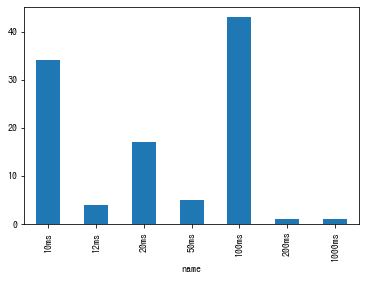

In [30]:
df_bins_sub = df_bins[df_bins["n_count"] > 0]
df_bins_sub["name"] = ["10ms", "12ms", "20ms", "50ms", "100ms", "200ms", "1000ms"]
df_bins_sub.set_index("name", inplace=True)
df_bins_sub["n_count"].plot(kind="bar");

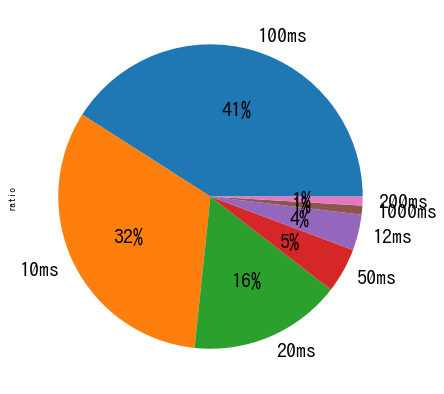

In [31]:
plt.figure(figsize=(7,7))
df_bins_sub["ratio"].sort_values(ascending=False).plot(kind="pie", autopct='%1.f%%',
                                                      fontsize=20)

### サンプリングの実行

#### 短期のサンプリング(同一ファイル内=600秒以内でのサンプリング)

例えば100Hzの時系列、すなわち10ms間隔の時系列データに変換する場合は、ほとんどのセンサーは計測時間間隔が10msより長いので、アップサンプリングと言える。  
他方、1Hzの時系列、すなわち1s間隔の時系列データに変換する場合は、ほとんどのセンサーは計測時間間隔が1sより短いので、ダウンサンプリングといえる。  
50Hz、すなわち20ms間隔の時系列データに変換する場合は、センサーの計測時間間隔によって、ダウンサンプリングとアップサンプリングが混在することとなる。

ここではどのような時間間隔でデータが来ても良いように、ダウンサンプリングとアップサンプリングを両方行う。どちらを先にやるかによって若干値は変わるが、大きな違いはないと考えられる。  
ここでは計算の効率性を考えて、ダウンサンプリングを行ったのち、アップサンプリングを行う。

ここでは、車両センサーを用いた先行研究で多く見られた、10Hz(100ms間隔)の時系列データを作成する。  
情報ロスを最小にしたい場合も、最も細かい計測時間間隔にあわせて100Hzの時系列データを作成すれば十分であろう。
また、長期の挙動でクラスタリングをかけたいのであれば、下記のような、同一ファイル(600秒データ)内でのサンプリングでは不要である。

In [32]:
# timesの最小値、最大値をチェック
df_selected.agg(func.max("times").alias("max_times")
               ,func.min("times").alias("min_times")).show()

+----------+---------+
| max_times|min_times|
+----------+---------+
|599.238639| 0.190403|
+----------+---------+



In [33]:
min_unit, max_unit = 1, 6000
sampling_rate = 10
round_decimal = 1

In [34]:
# 今回の場合は、100ms = 0.1s間隔でダウンサンプリングするために、0.1s間隔のテーブルを作成する
# 今回の場合は0.1s ~ 600.0sで作成される
time_grid = (spark.range(start=min_unit, end=max_unit)
             .select((func.col("id").cast("float") / sampling_rate)
            .alias("times")))
time_grid.show(5)

+-----+
|times|
+-----+
|  0.1|
|  0.2|
|  0.3|
|  0.4|
|  0.5|
+-----+
only showing top 5 rows



In [35]:
# サンプリングレートでtimesを丸めた列(rounded_times)を作っておく
df_selected = df_selected.withColumn("rounded_times",
                                    func.round("times", round_decimal))

In [36]:
# 0.1間隔で各センサー毎に値の平均値を取る。
# (0.1間隔のテーブルに、rounded_timesでデータをinner join、0.1間隔の時間でgroupbyしてvalの平均を取る。)
df_downsampled = (time_grid
           .join(df_selected,
                 time_grid.times == df_selected.rounded_times)
           .groupBy(["carid", "feature", "starttime", time_grid.times])
           .agg(func.mean("val").alias("avg_val")))

In [37]:
df_downsampled.show()

Row(carid='021', feature='3D047', starttime='201604200627', times=0.5, avg_val=0.0)

In [112]:
# アップサンプリング(線形補間)用に、0.1sで丸められたテーブルについて、1時点前のtimesと値(avg_val)の列をつくっておく
# lagを使うと先頭がnullができてしまうので、最後にfilterとisNotNullを使って取り除いておく
df_downsampled = (df_downsampled
                  .withColumn("prev_val", func.lag("avg_val")
                              .over(Window.partitionBy(["carid", "starttime", "feature"])
                                    .orderBy("times")))
                  .withColumn("prev_times", func.lag("times")
                              .over(Window.partitionBy(["carid", "starttime", "feature"])
                                    .orderBy("times"))))
                  
df_downsampled = df_downsampled.filter((df_downsampled["prev_val"].isNotNull()) &
                                       (df_downsampled["prev_times"].isNotNull()))

In [125]:
# アップサンプリング用の0.1s間隔のテーブル。
# 別テーブルで用意しておく必要があることに注意。
# というのも、同じテーブルでjoinすると、最後にsparkが計算するときに、内部でSQLの解釈&最適化が行われるのだが、
# その際に正しく解釈が行われない。
time_grid_2 = (spark.range(start=min_unit, end=max_unit)
             .select((func.col("id").cast("float") / sampling_rate)
            .alias("times")))

In [126]:
# 0.1s間隔にアップサンプリングを行う。
# 0.1s間隔のテーブルに、prev_timesとtimesの間に来るようにjoinし、線形補間を行う。
df_intp = (time_grid_2
           .join(df_downsampled,
                 [(df_downsampled.prev_times <= time_grid_2.times) & 
                  (time_grid_2.times < df_downsampled.times)])
           .select(df_downsampled.carid, df_downsampled.feature, df_downsampled.starttime
                  ,time_grid_2.times
                  ,(df_downsampled.prev_val + 
                    (df_downsampled.avg_val - df_downsampled.prev_val) 
                    * (time_grid_2.times - df_downsampled.prev_times)
                    / (df_downsampled.times - df_downsampled.prev_times)).alias("intp_val")
                  )
          )

In [127]:
df_intp.show()

+-----+-------+------------+-----+--------+
|carid|feature|   starttime|times|intp_val|
+-----+-------+------------+-----+--------+
|  021|  1EF61|201604200627|  0.3|     0.0|
|  021|  1EF61|201604200627|  0.4|     0.0|
|  021|  1EF61|201604200627|  0.5|     0.0|
|  021|  1EF61|201604200627|  0.6|   0.025|
|  021|  1EF61|201604200627|  0.7|     0.0|
|  021|  1EF61|201604200627|  0.8|     0.0|
|  021|  1EF61|201604200627|  0.9|     0.0|
|  021|  1EF61|201604200627|  1.0|     0.0|
|  021|  1EF61|201604200627|  1.1|     0.0|
|  021|  1EF61|201604200627|  1.2|     0.0|
|  021|  1EF61|201604200627|  1.3|     0.0|
|  021|  1EF61|201604200627|  1.4|   0.025|
|  021|  1EF61|201604200627|  1.5|     0.0|
|  021|  1EF61|201604200627|  1.6|     0.0|
|  021|  1EF61|201604200627|  1.7|     0.0|
|  021|  1EF61|201604200627|  1.8|  0.0375|
|  021|  1EF61|201604200627|  1.9|     0.0|
|  021|  1EF61|201604200627|  2.0|     0.0|
|  021|  1EF61|201604200627|  2.1|     0.0|
|  021|  1EF61|201604200627|  2.

In [131]:
# 処理後のデータを保存しておく。
df_intp.write.parquet("../data/interim/df_intp_Job1_2file.parquet")

In [160]:
# csvで分けて保存することもできる。
df_intp.write.partitionBy(["feature","starttime"]).csv("../data/interim/df_intp_Job1_2file.csv")

In [135]:
df_intp_2 = spark.read.parquet("../data/interim/df_intp_Job1_2file.parquet/")

# 良さそうかいくつか図示してみて確認
df_tmp = df_intp_2.filter(df_intp_2.feature.isin(selected_features[:5])).toPandas()

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt

In [151]:
import pandas as pd

In [152]:
df_raw = pd.read_csv("../data/raw/CAN/20190605_CAN/103.486_CAR1V21_HDD2/Job1/"
           + "SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
                     names=["carid", "starttime", "times", "feature", "val"])

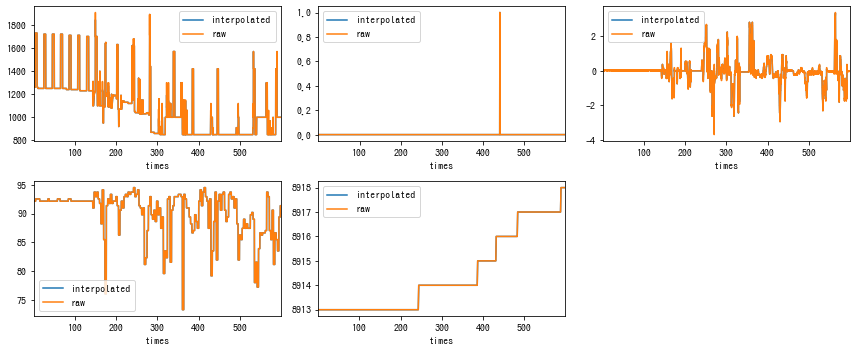

In [153]:
fig = plt.figure(figsize=(12, 5))
for i, f in enumerate(df_tmp.feature.unique()):
    ax = fig.add_subplot(2, 3, i+1)
    tmp_intp = df_tmp.loc[(df_tmp.feature == f) & (df_tmp.starttime == "201604200627")]
    tmp_raw = df_raw.loc[(df_raw.feature == f) & (df_raw.starttime == 201604200627)]
    tmp_intp.set_index("times")["intp_val"].plot(ax=ax, label="interpolated")
    tmp_raw.set_index("times")["val"].plot(ax=ax, label="raw")
    plt.legend()
plt.tight_layout()

In [154]:
df_raw = pd.read_csv("../data/raw/CAN/20190605_CAN/103.486_CAR1V21_HDD2/Job1/"
           + "SUZUKI_YSB-021_MRR_2016-04-20_06-37_0002.BLF.csv",
                     names=["carid", "starttime", "times", "feature", "val"])

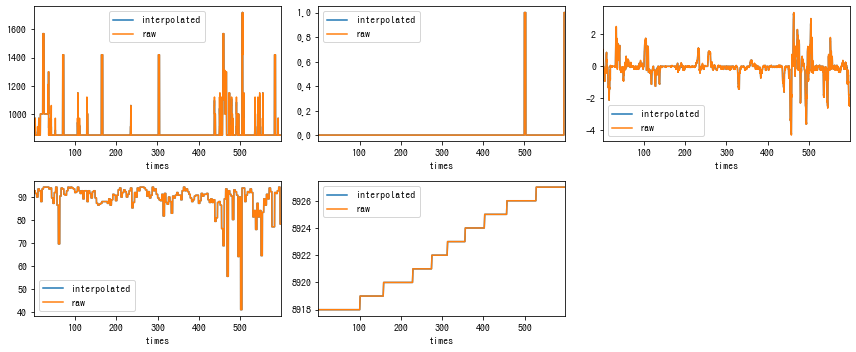

In [155]:
fig = plt.figure(figsize=(12, 5))
for i, f in enumerate(df_tmp.feature.unique()):
    ax = fig.add_subplot(2, 3, i+1)
    tmp_intp = df_tmp.loc[(df_tmp.feature == f) & (df_tmp.starttime == "201604200637")]
    tmp_raw = df_raw.loc[(df_raw.feature == f) & (df_raw.starttime == 201604200637)]
    tmp_intp.set_index("times")["intp_val"].plot(ax=ax, label="interpolated")
    tmp_raw.set_index("times")["val"].plot(ax=ax, label="raw")
    plt.legend()
plt.tight_layout()

In [158]:
# 今後の利用を考えて、横持ちでも保存しておく。
(df_intp_2
 .groupby(["carid", "starttime", "times"])
 .pivot("feature")
 .agg(func.first("intp_val"))
 .write.parquet("../data/interim/df_intp_Job1_2file_pivoted.parquet"))

#### ファイル単位でのサンプリング

長期の特徴量を用いてサンプリングしたい場合は、ファイル単位でサンプリングを行う。  
以下に例を示す。

In [38]:
# 読み込み
df_all = spark.read.csv("../data/raw/CAN/20190605_CAN/103.486_CAR1V21_HDD2/Job1/*.csv",
                       schema=schema)

In [39]:
from pyspark.sql.functions import col

In [186]:
# 変化しない変数を落とした後、starttimeを1時間毎にまるめる
df_all = (df_all.
          filter(df_all.feature.isin(selected_features))
          .withColumn("starttime", func.to_timestamp(df_all.starttime, format="yyyyMMddHHmm"))
          .withColumn("rounded_starttime", (func.round(func.unix_timestamp(col("starttime")) / 3600) * 3600)
                      .cast("timestamp")))

In [187]:
df_all.show(5)

+-----+-------------------+--------+-------+--------+-------------------+
|carid|          starttime|   times|feature|     val|  rounded_starttime|
+-----+-------------------+--------+-------+--------+-------------------+
|  021|2016-04-20 07:50:00|0.186631|  12461|     1.0|2016-04-20 08:00:00|
|  021|2016-04-20 07:50:00|0.186631|  12464|     0.0|2016-04-20 08:00:00|
|  021|2016-04-20 07:50:00|0.186631|  12457|5.490196|2016-04-20 08:00:00|
|  021|2016-04-20 07:50:00|0.186631|  12437|   850.0|2016-04-20 08:00:00|
|  021|2016-04-20 07:50:00|0.186631|  12417|  1784.0|2016-04-20 08:00:00|
+-----+-------------------+--------+-------+--------+-------------------+
only showing top 5 rows



rounded_starttimeとcaridを利用して集約する。  
もしVIN毎に特性をみたいのであれば、caridのみで集約すればよい。  
また、今回は時間(rounded_starttime)で線形補間をかけていない。というのも、例えば朝と夕方に運転したとして、途中運転しなかった昼について線形補間をかけることは、"運転のクラスタリングのための特徴量の作成"という目的にそぐわないためである。

In [182]:
calc_1stQ_val = func.expr("percentile_approx(val, 0.25)")
calc_median_val = func.expr("percentile_approx(val, 0.5)")
calc_3rdQ_val = func.expr("percentile_approx(val, 0.75)")

In [188]:
# 色々な方法で集約する。
# 今回は、標準偏差、平均、最大値、最小値、25%-tile、中央値、75%-tileで集約した。
df_aggregated = (df_all
                 .groupBy(["carid", "rounded_starttime", "feature"])
                 .agg(func.stddev("val").alias("sd_val"), 
                      func.mean("val").alias("mean_val"),
                      func.max("val").alias("max"),
                      func.min("val").alias("min"),
                      calc_1stQ_val.alias("Q1"),
                      calc_median_val.alias("median"),
                      calc_3rdQ_val.alias("Q3")))

In [195]:
# carid毎に、ヘッダ有りのcsvで保存する場合
df_aggregated.write.partitionBy("carid").csv("../data/interim/df_hourly_Job1.csv",
                                       header=True)

In [196]:
# parquetでも保存しておく
df_aggregated.write.partitionBy("carid").parquet("../data/interim/df_hourly_Job1.parquet")

In [203]:
df_aggregated = spark.read.parquet("../data/interim/df_hourly_Job1.parquet/")

In [204]:
df_aggregated.show(10, truncate=10)

+-----------------+-------+----------+----------+---------+------+-------+--------+---------+-----+
|rounded_starttime|feature|    sd_val|  mean_val|      max|   min|     Q1|  median|       Q3|carid|
+-----------------+-------+----------+----------+---------+------+-------+--------+---------+-----+
|       2016-04...|  3A116|       0.0|       0.0|      0.0|   0.0|    0.0|     0.0|      0.0|   21|
|       2016-04...|  3A107|       0.0|       0.0|      0.0|   0.0|    0.0|     0.0|      0.0|   21|
|       2016-04...|  3D016|0.41478...|0.22074...|      1.0|   0.0|    0.0|     0.0|      0.0|   21|
|       2016-04...|  1E823|0.69256...|-0.0345...|     3.49| -3.98|  -0.23|     0.0|     0.09|   21|
|       2016-04...|  3A116|0.25910...|0.07235...|      1.0|   0.0|    0.0|     0.0|      0.0|   21|
|       2016-04...|  1EF61|0.48085...|0.06032...|    4.375|-3.625|-0.0625|  0.0625|   0.1875|   21|
|       2016-04...|  0FA37|1.11803...|1.50000...|      3.0|   0.0|    1.0|     2.0|      3.0|   21|


## 使用する変数を再度選択

### 変数同士の相関係数

In [40]:
df_intp_2 = spark.read.parquet("../data/interim/df_intp_Job1_2file_pivoted.parquet/")

In [41]:
# はじめの10列を表示
df_intp_2.select(df_intp_2.columns[:10]).show(5)

+-----+------------+-----+-----+-----+-----+-----+-----+-----+------+
|carid|   starttime|times|0FA37|0FA57|11451|11467|11913|11915| 11927|
+-----+------------+-----+-----+-----+-----+-----+-----+-----+------+
|  021|201604200627|491.0|  1.7|  5.2|  1.5|  1.5|  3.7|  1.5|  -1.9|
|  021|201604200627| 23.9|  1.7|  5.2|  1.7|  1.3|  9.1|  1.5|-12.27|
|  021|201604200637|167.5|  1.7|  5.2|  1.5|  1.5|  6.5|  1.5|  -0.7|
|  021|201604200637|432.4|  1.5|  6.0|  1.3|  1.7| 10.5|  1.5|  -1.7|
|  021|201604200637|490.0|  1.3|  6.8|  1.5|  1.5|  7.0|  1.3| -11.6|
+-----+------------+-----+-----+-----+-----+-----+-----+-----+------+
only showing top 5 rows



#### SparkMLエンジンを利用する方法

In [44]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=[c for c in df_intp_2.columns[3:]], 
                            outputCol="vector_features")
df_vec = assembler.transform(df_intp_2.dropna()).select("carid", "starttime", "times", "vector_features")

In [45]:
df_vec.show(5)

+-----+------------+-----+--------------------+
|carid|   starttime|times|     vector_features|
+-----+------------+-----+--------------------+
|  021|201604200627|491.0|[1.7,5.2,1.5,1.5,...|
|  021|201604200627| 23.9|(105,[0,1,2,3,4,5...|
|  021|201604200637|167.5|[1.7,5.2,1.5,1.5,...|
|  021|201604200637|432.4|[1.5,6.0,1.3,1.7,...|
|  021|201604200637|490.0|[1.3,6.8,1.5,1.5,...|
+-----+------------+-----+--------------------+
only showing top 5 rows



In [46]:
from pyspark.ml.stat import Correlation

In [47]:
r1 = Correlation.corr(df_vec, "vector_features").head()

In [48]:
np_corr_matrix = r1[0].toArray()

In [49]:
import pandas as pd

In [50]:
df_corr = pd.DataFrame(np_corr_matrix, index=df_intp_2.columns[3:], columns=df_intp_2.columns[3:])

In [51]:
import seaborn as sns

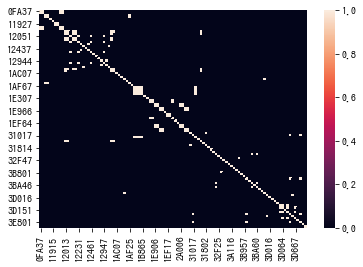

In [52]:
sns.heatmap(df_corr.abs() > 0.9)

In [53]:
((df_corr.abs() > 0.9).sum().sum() - df_corr.shape[0])/2

78.0

相関が高いペアが78ペアあった

### 自己相関関数

## 使用するクラスター数(ハイパーパラメータ)と変数を選択

## クラスタリングを実行

## クラスタを解釈

宿題: EVデータをPySparkを使用して、データの線形補間/相関計算を行う